# Clustering Solution Generator
### $Time$ $Series$ $4th$ $Test$

$Vasco$ $Mergulhão$ $-$ $April$ $2023$

### Version 1:
This script loads a model and outputs a CSV ready to be analysed on the Dashboard

In [188]:
import os  

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import groupby
from datetime import timedelta, date
import plotly.graph_objects as go
import scipy
import math
from sklearn.cluster import KMeans

import random

import time
import datetime

import umap # UMAP library is responsible for ipywidgets warning!

import tensorflow as tf
from tensorflow import keras
from keras import models

import wandb
from wandb.keras import WandbCallback

import Transform

In [189]:
# Set Random Seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

---
# Script Variables

In [190]:
# MANUAL INPUTS
# MAKE SURE THEY ARE CORRECT
# Everything else is automated
dataset_name = 'Kenya_90k_Set_1_w90_pW'
Model_Name = 'LSTM_AE' # Options: FC_N2D, LSTM_AE, CNN_AE, CNN_ConvEmb
solution_name = 'efficient-sweep-2:v49'

# This loads model by name.
# Identify the best model by navigating the WandB Sweeps page.
# Find link to best model (and version)  in Artifacts -> Usage, and copy directory.
# .pb format is only accepted by Tensorflow, NOT Keras.
##############################################################################



In [191]:
# Uses name to navigate folders
window_cols, window_len = Transform.retrive_window_col_names(dataset_name)
dataset_folder = "_".join(dataset_name.split('_')[:-2]) 
dataset_location = f'../Data_Storage_Processing/Data/{dataset_folder}/{dataset_name}.csv'


# Project Name
scaler_dict = {'Orig':'OriginalScale',
               'pW':'pWindow',
               'G':'Gobal'}
dataset_name_base = "_".join(dataset_name.split('_')[:-1])
scaler_used = dataset_name.split('_')[-1]

Project_Name = f'DeepClust--{dataset_name_base}--{scaler_dict[scaler_used]}'

---
# Data Imports

In [192]:
Data = pd.read_csv(dataset_location)

In [193]:
Data = Data[:1000]

In [194]:
Data.head()

,short_ID,window_ID,window_start_date,d1,d2,d3,d4,d5,d6,d7,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,127,0,2018-01-20,0.543805,0.503693,0.463580,0.423467,0.383355,0.343242,0.303129,...,0.906409,0.904819,0.864707,0.786444,0.784481,0.706456,0.666459,0.626384,0.586360,0.583918
1,127,1,2018-04-20,0.525359,0.522565,0.480950,0.439334,0.397718,0.317612,0.314487,...,1.019053,0.977438,0.935822,0.894206,0.852591,0.810975,0.769359,0.727744,0.686128,0.644512
2,127,2,2018-07-19,0.651208,0.606258,0.561307,0.516357,0.471407,0.426456,0.381506,...,1.013146,0.968196,0.923246,0.878295,0.833345,0.788395,0.743444,0.698494,0.653543,0.608593
3,127,3,2018-10-17,0.594276,0.546883,0.499489,0.452096,0.404703,0.357309,0.309916,...,0.499489,0.452096,0.404703,0.357309,0.309916,0.262522,0.215129,0.167736,0.120342,0.072949
4,127,4,2019-01-15,0.953922,0.853922,0.753922,0.653922,0.553922,0.453922,0.353922,...,0.453922,0.353922,0.253922,0.153922,0.753922,0.653922,0.553922,0.453922,0.353922,2.000000


## Reshaping Data

In [195]:
if Model_Name == 'FC_N2D':
    predict_data =  Data[window_cols].to_numpy()
else:
    predict_data =  Data[window_cols].to_numpy().reshape(-1, window_len, 1)

In [196]:
predict_data.shape

(1000, 90, 1)

---
---
# Loading Model

In [197]:
run = wandb.init()
model_artifact = run.use_artifact(f'vasco-phd/{Project_Name}/model-{solution_name}', type='model')
model_dir = model_artifact.download()
# local_model_dir = 'C:/Users/ucesvpm/OneDrive - University College London/PhD Project/Data Analytics/Time Series Clustering/Second Test/wandb/run-20221213_173041-jc918077'
loaded_autoencoder = tf.keras.models.load_model(model_dir)
run.finish()

wandb:   4 of 4 files downloaded.  


In [198]:
loaded_autoencoder.summary()

Model: "LSTM_AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90, 1)]           0         
                                                                 
 Encoder (LSTM)              (None, 90, 100)           40800     
                                                                 
 Lantent_Space (LSTM)        (None, 25)                12600     
                                                                 
 Reshape_Embeding (RepeatVec  (None, 90, 25)           0         
 tor)                                                            
                                                                 
 Decoder_1 (LSTM)            (None, 90, 25)            5100      
                                                                 
 Decoder_2 (LSTM)            (None, 90, 100)           50400     
                                                           

In [199]:
# bottleneck model
encoder_output = loaded_autoencoder.get_layer('Lantent_Space').output
encoder = models.Model(inputs = loaded_autoencoder.input, outputs = encoder_output, name = f'{Model_Name}_encoder')
encoder.summary()

Model: "LSTM_AE_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90, 1)]           0         
                                                                 
 Encoder (LSTM)              (None, 90, 100)           40800     
                                                                 
 Lantent_Space (LSTM)        (None, 25)                12600     
                                                                 
Total params: 53,400
Trainable params: 53,400
Non-trainable params: 0
_________________________________________________________________


---
# Saving Encoder

In [200]:
solution_fileName = solution_name.replace(":", "-" ).replace("-", "_" )
Encoder_Name = f'{Model_Name}-{solution_fileName}'
# encoder.save(f'SavedModels/{Encoder_Name}')

---
#  Reconstruction Error

In [201]:
# Calculates the RModelontruction Profiles (Predictions)
reconstruct_data = loaded_autoencoder.predict(predict_data)

32/32 [==============================] - 3s 44ms/step


In [202]:
# Saves the Reconstructect windows
df_reconstruct = Data[['short_ID', 'window_ID']].copy(deep=True)
if Model_Name == 'FC_N2D':
    df_reconstruct[window_cols] = reconstruct_data
else:
    df_reconstruct[window_cols] = reconstruct_data.reshape(-1, window_len)

In [203]:
# Calculating MSE per window
MSE = tf.keras.losses.MeanSquaredError(reduction='none')
if Model_Name == 'FC_N2D':
    MSE_values = MSE(predict_data, reconstruct_data).numpy()
else:
    MSE_values = MSE(predict_data.reshape(-1, window_len), reconstruct_data.reshape(-1, window_len)).numpy()
#Adding to reconstructed dataframe
df_reconstruct.insert(loc=2, column='MSE', value=MSE_values)

In [204]:
df_reconstruct.head()

,short_ID,window_ID,MSE,d1,d2,d3,d4,d5,d6,d7,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,127,0,0.036224,0.551866,0.511525,0.418921,0.393570,0.376943,0.354484,0.342850,...,0.918718,0.906462,0.890662,0.858993,0.806989,0.740205,0.668449,0.601423,0.551958,0.541089
1,127,1,0.001781,0.511137,0.535627,0.456171,0.430780,0.399154,0.356051,0.327404,...,1.020759,0.995790,0.969248,0.935301,0.888822,0.829687,0.764942,0.704779,0.660446,0.643842
2,127,2,0.008751,0.540324,0.648341,0.572467,0.494882,0.453017,0.394184,0.348231,...,0.935303,0.903605,0.875646,0.850747,0.823421,0.788953,0.749272,0.711617,0.685288,0.679950
3,127,3,0.003819,0.503273,0.541258,0.460892,0.437429,0.392647,0.366842,0.359645,...,0.443012,0.411199,0.390286,0.376721,0.359625,0.327530,0.277821,0.214182,0.147162,0.123559
4,127,4,0.057101,1.141542,0.830329,0.652757,0.551421,0.494866,0.487153,0.502427,...,0.576964,0.515441,0.453450,0.377552,0.284933,0.226393,0.501658,1.006430,0.971729,0.888564


---
---
# 2D UMAP

In [205]:
def UMAP_funct (data, dims = 2, mode = 'visualisation'):
    # this function allows you to switch from the settings optimazed from visualisation to clustering more easily
    start_time = time.time()
    if mode == 'visualisation':
        print(f'Processing UMAP {dims}D-Viz')
        umap_model = umap.UMAP(random_state=42, n_components = dims).fit(data)
        umap_data = umap_model.transform(data)
        print(f'Time: {np.round(time.time() - start_time,2)}[s]') 
        
        return umap_data, umap_model
    
    elif mode == 'clustering':
        
        print(f'Processing UMAP {dims}D-Clust')
        # Settings from https://umap-learn.readthedocs.io/en/latest/clustering.html
        # General idea is larger n_neighbors to capture wider relationships, and smaller min_dist to keep points closer (better for density alg)   
        umap_model = umap.UMAP(random_state=42,
                               n_components = dims,
                               n_neighbors=30,
                               min_dist=0.0
                              ).fit(data)
        
        umap_data = umap_model.transform(data)

        
        print(f' UMAP Time: {np.round(time.time() - start_time,2)}[s]') 
        
        return umap_data, umap_model
    else:
        print(f'UMAP mode {mode} NOT recognized.')

In [206]:
# Calculating Latent Space Projection
encoded_data = encoder.predict(predict_data)

32/32 [==============================] - 2s 32ms/step


In [207]:
 # encoded_data = encoded_data.numpy()
df_encoded = pd.DataFrame(encoded_data)

In [208]:
#Calcs UMAP for Visual Purposes  
v_2D_umap, umap_model = UMAP_funct (encoded_data, dims = 2, mode = 'visualisation')

Processing UMAP 2D-Viz
Time: 10.17[s]


In [209]:
# Creates DF for Clustering Solutions
df_sols  = Data.copy(deep=True)
df_sols.drop(window_cols, axis=1, inplace=True)

In [210]:
#Adds Dims to Dataframes
df_sols['UMAP_V1'] = v_2D_umap[:, 0]
df_sols['UMAP_V2'] = v_2D_umap[:, 1]

df_reconstruct.insert(loc=2, column='UMAP_V2', value=v_2D_umap[:, 1])
df_reconstruct.insert(loc=2, column='UMAP_V1', value=v_2D_umap[:, 0])

---
---
# Clustering Solutions

### kMeans

In [215]:
def kMeans_cluster(Encoded_Data, UMAP_mode = False, Max_k = 25):
    # Uses kMeans on encoded dataset.
    # UMAP_mode uses N2D-paper recomendation of UMAP encoded data to where k = Dims.
    
    # Output DF, only has solution columns
    df_kMeans_sols = pd.DataFrame()
    # df_kMeans_centroids = pd.DataFrame()
    start_time = time.time()
    
    
    # k-Means on Embeded Space
    kmeans = [KMeans(n_clusters=k, random_state=42).fit(Encoded_Data)
              for k in range(2, Max_k + 1)]

    # Saving Centroid, in Clustering Space Dimensions
    clust_sol_names = []
    centroids = []
    centroid_dim_cols = None
    for partition in kmeans:
        cluster_k = partition.labels_.max() + 1
        sol_name = f'kMeans_k{cluster_k}'
        df_kMeans_sols[sol_name] = partition.labels_ + 1
    
    # kMeans in UMAP projection, a.k.a KUMAP
    if UMAP_mode == True:
        print('Clustering on UMAP of Encoded Space')
        for k in range(2, Max_k + 1):
            # UMAPing to macthed k=dims with cluster friendly settings
            clust_umap, umap_model = UMAP_funct (Encoded_Data, dims = k, mode = 'clustering')
            print(f'Processing kMeans for k={k}\n')
            partition = KMeans(n_clusters=k, random_state=42).fit(clust_umap)
            col_name = f'KUMAP_k{k}'
            df_kMeans_sols[col_name] = partition.labels_ + 1
 
    print(f'Total Time: {np.round(time.time() - start_time,2)}[s]')         
    return df_kMeans_sols

In [214]:
kMeans_sols = kMeans_cluster(df_encoded, UMAP_mode = True, Max_k = 25)

C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklea

Clustering on UMAP of Encoded Space
Processing UMAP 2D-Clust
 UMAP Time: 3.93[s]
Processing kMeans for k=2



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 3D-Clust
 UMAP Time: 4.04[s]
Processing kMeans for k=3



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 4D-Clust
 UMAP Time: 6.08[s]
Processing kMeans for k=4



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 5D-Clust
 UMAP Time: 4.56[s]
Processing kMeans for k=5



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 6D-Clust
 UMAP Time: 5.93[s]
Processing kMeans for k=6



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 7D-Clust
 UMAP Time: 5.7[s]
Processing kMeans for k=7



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 8D-Clust
 UMAP Time: 5.02[s]
Processing kMeans for k=8



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 9D-Clust
 UMAP Time: 4.84[s]
Processing kMeans for k=9



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 10D-Clust
 UMAP Time: 5.46[s]
Processing kMeans for k=10



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 11D-Clust
 UMAP Time: 5.22[s]
Processing kMeans for k=11



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 12D-Clust
 UMAP Time: 5.55[s]
Processing kMeans for k=12



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 13D-Clust
 UMAP Time: 6.08[s]
Processing kMeans for k=13



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 14D-Clust
 UMAP Time: 5.83[s]
Processing kMeans for k=14



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 15D-Clust
 UMAP Time: 6.08[s]
Processing kMeans for k=15



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 16D-Clust
 UMAP Time: 6.4[s]
Processing kMeans for k=16



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 17D-Clust
 UMAP Time: 6.22[s]
Processing kMeans for k=17



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 18D-Clust
 UMAP Time: 7.57[s]
Processing kMeans for k=18



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 19D-Clust
 UMAP Time: 7.25[s]
Processing kMeans for k=19



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 20D-Clust
 UMAP Time: 6.79[s]
Processing kMeans for k=20



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 21D-Clust
 UMAP Time: 9.46[s]
Processing kMeans for k=21



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 22D-Clust
 UMAP Time: 9.04[s]
Processing kMeans for k=22



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 23D-Clust
 UMAP Time: 7.14[s]
Processing kMeans for k=23



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 24D-Clust
 UMAP Time: 10.08[s]
Processing kMeans for k=24



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Processing UMAP 25D-Clust
 UMAP Time: 9.47[s]
Processing kMeans for k=25



C:\Users\ucesvpm\Anaconda3\envs\TensorFlow_PhD\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Total Time: 169.91[s]


In [217]:
df_sols = pd.concat([df_sols, kMeans_sols], axis=1)

In [220]:
df_sols.head()

,short_ID,window_ID,window_start_date,UMAP_V1,UMAP_V2,kMeans_k2,kMeans_k3,kMeans_k4,kMeans_k5,kMeans_k6,...,KUMAP_k=16,KUMAP_k=17,KUMAP_k=18,KUMAP_k=19,KUMAP_k=20,KUMAP_k=21,KUMAP_k=22,KUMAP_k=23,KUMAP_k=24,KUMAP_k=25
0,127,0,2018-01-20,13.215649,10.688394,1,3,1,4,6,...,3,10,13,7,9,8,12,17,12,9
1,127,1,2018-04-20,13.076130,10.641882,1,3,1,4,6,...,3,10,13,7,9,8,12,17,12,9
2,127,2,2018-07-19,14.080730,10.173175,1,3,1,4,6,...,16,1,11,3,20,11,15,6,17,12
3,127,3,2018-10-17,14.164723,9.808705,1,3,1,4,6,...,16,17,10,11,6,2,13,19,17,5
4,127,4,2019-01-15,14.392631,10.203107,1,3,1,4,6,...,16,17,10,11,6,2,13,19,17,5


## kMeans Centroids

> ***Note***:  
> These are calculated **a posteriori**.  
> Because the definition of centroid is the mean of all points, for an Eucledian space.  
> Plus, with the several inverse transformations, there is a lot of error amplification potential if <code>kmeans.cluster_centers_</code> is used.

In [246]:
def kmeans_centroids (df_orig, df_kmeans_sols):
    
    clust_sol_cols = df_kmeans_sols.columns[5:]    
    df_centroids = pd.DataFrame()
    
    centroids = []
    sol_names = []
    for clust_sol in clust_sol_cols:
        n_clusters = df_kmeans_sols[clust_sol].max()
        
        for c in range(1, n_clusters +1):
            clust_idx = df_kmeans_sols[df_kmeans_sols[clust_sol] == c].index
            centroid = df_orig[window_cols].iloc[clust_idx].mean()
            centroids.append(centroid)
            
            sol_name = clust_sol + f'-c{c}'
            sol_names.append(sol_name)
    
    df_centroids['Clust_Sols'] = sol_names
    df_centroids[window_cols] = centroids
        
    return df_centroids #clust_idx, centroid

In [247]:
df_centroids = kmeans_centroids (Data, df_sols)

<Axes: >

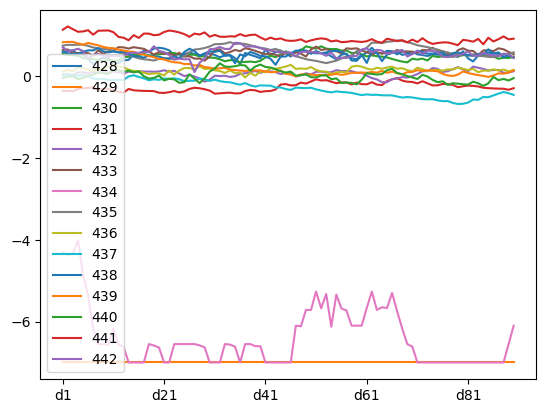

In [267]:
sol = 'KUMAP_k=15'
sol_rows = df_centroids['Clust_Sols'][df_centroids['Clust_Sols'].str.contains(sol)]
df_centroids[window_cols][df_centroids['Clust_Sols'].isin(sol_rows)].T.plot()

<Axes: >

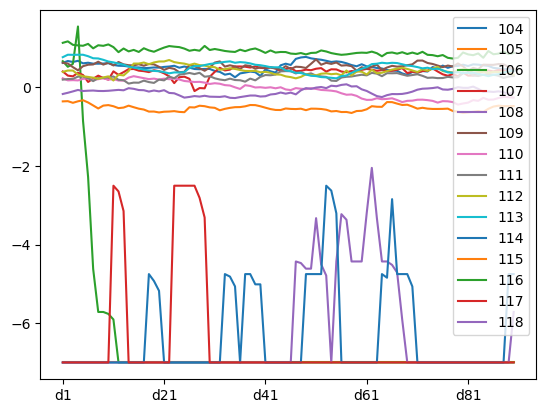

In [268]:
sol = 'kMeans_k15'
sol_rows = df_centroids['Clust_Sols'][df_centroids['Clust_Sols'].str.contains(sol)]
df_centroids[window_cols][df_centroids['Clust_Sols'].isin(sol_rows)].T.plot()

In [259]:
df_centroids

,Clust_Sols,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,kMeans_k2-c1,0.334658,0.343587,0.322109,0.333589,0.312088,0.282053,0.235207,0.250145,0.240007,...,0.131280,0.135520,0.130736,0.134626,0.148448,0.140359,0.150217,0.148680,0.143069,0.154236
1,kMeans_k2-c2,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
2,kMeans_k3-c1,-4.315424,-4.365424,-4.339589,-4.006331,-4.848047,-5.348009,-6.166704,-6.550000,-6.550000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-6.550000,-6.100000
3,kMeans_k3-c2,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000
4,kMeans_k3-c3,0.438339,0.448582,0.426048,0.430355,0.427141,0.407584,0.377947,0.401765,0.391400,...,0.290283,0.294618,0.289727,0.293704,0.307834,0.299564,0.309642,0.308071,0.292301,0.293684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,KUMAP_k=25-c21,1.674720,1.770362,1.667970,1.670204,1.709288,1.734242,1.701776,1.721131,1.864677,...,1.623079,1.604249,1.638835,1.595709,1.688036,1.562982,1.593954,1.523091,1.553571,1.526097
644,KUMAP_k=25-c22,0.411492,0.251419,0.380235,0.307541,0.263617,0.223087,0.074923,-0.000242,-0.043543,...,0.435286,0.381125,0.453459,0.529400,0.489061,0.462053,0.317579,0.436525,0.428585,0.366577
645,KUMAP_k=25-c23,0.121630,0.143466,0.014131,-0.048842,0.003282,-0.083537,-0.089820,-0.075872,-0.009362,...,-0.090372,-0.003546,-0.066316,-0.026164,0.028090,0.104497,-0.001459,0.021199,0.025292,0.017763
646,KUMAP_k=25-c24,0.486370,0.712061,0.616816,0.676865,0.621006,0.677565,0.625289,0.572126,0.606150,...,0.728031,0.783138,0.639943,0.640770,0.584598,0.593145,0.697958,0.571559,0.476062,0.202521


### HDBSCAN
TBC

---
---
# Saving Outputs

### Clustering Solutions

In [27]:
df_sols.head()

,short_ID,window_ID,window_start_date,UMAP_V1,UMAP_V2,kMeans_k=2,kMeans_k=3,kMeans_k=4,kMeans_k=5,kMeans_k=6,kMeans_k=7,kMeans_k=8,kMeans_k=9,kMeans_k=10
0,127,0,2018-01-20,10.871482,2.438664,1,1,3,4,2,1,7,9,4
1,127,1,2018-04-20,10.872495,2.421228,1,1,3,4,2,1,7,9,4
2,127,2,2018-07-19,6.726967,2.628829,1,1,3,4,2,1,7,1,8
3,127,3,2018-10-17,6.605581,2.937758,1,1,3,4,2,1,7,1,4
4,127,4,2019-01-15,7.054455,2.544774,1,1,3,4,2,1,7,1,8


In [28]:
os.makedirs(f'../ModelResults/Clustering/{dataset_name}', exist_ok=True)  
solution_fileName = solution_name.replace(":", "-" ).replace("-", "_" )
solution_fileName = f'{Model_Name}-{solution_fileName}.csv'
# df_sols.to_csv(f'../ModelResults/Clustering/{dataset_name}/{solution_fileName}', index=False)  


In [29]:
solution_fileName

'LSTM_AE-efficient_sweep_2_v49.csv'

### Auto-Encoder Recontruction

In [30]:
df_reconstruct.head()

,short_ID,window_ID,UMAP_V1,UMAP_V2,MSE,d1,d2,d3,d4,d5,...,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90
0,127,0,10.871482,2.438664,0.036224,0.551866,0.511525,0.418921,0.393570,0.376943,...,0.918718,0.906462,0.890662,0.858993,0.806989,0.740205,0.668449,0.601423,0.551958,0.541089
1,127,1,10.872495,2.421228,0.001781,0.511137,0.535627,0.456171,0.430780,0.399154,...,1.020759,0.995790,0.969248,0.935301,0.888822,0.829687,0.764942,0.704779,0.660446,0.643842
2,127,2,6.726967,2.628829,0.008751,0.540324,0.648341,0.572467,0.494882,0.453017,...,0.935303,0.903605,0.875646,0.850747,0.823421,0.788953,0.749272,0.711617,0.685288,0.679950
3,127,3,6.605581,2.937758,0.003819,0.503273,0.541258,0.460892,0.437429,0.392647,...,0.443012,0.411199,0.390286,0.376721,0.359625,0.327530,0.277821,0.214182,0.147162,0.123559
4,127,4,7.054455,2.544774,0.057101,1.141542,0.830329,0.652757,0.551421,0.494866,...,0.576964,0.515441,0.453450,0.377552,0.284933,0.226393,0.501658,1.006430,0.971729,0.888564


In [31]:
os.makedirs(f'../ModelResults/AE_Reconstruction/{dataset_name}', exist_ok=True)  
# df_reconstruct.to_csv(f'../ModelResults/AE_Reconstruction/{dataset_name}/{solution_fileName}', index=False)  